In [1]:
using MyBioTools, MyBioTools.FluTools
using TreeTools
using Plots
using StatsBase, Statistics
using FastaIO
using Random
using Measures
using LaTeXStrings
using Dates

┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/MyBioTools.ji for MyBioTools [top-level]
└ @ Base loading.jl:1184


In [2]:
include("../../../make_all_plots.jl")

Pfix_vs_fitness (generic function with 1 method)

In [3]:
pyplot()
plot(rand(10),size=(1,1))

In [4]:
lfs = 16 # Legend font size
alfs = 18 # axis label font size
tfs = 18 # title font size
atfs = 18 # axis ticks font size
ga = 0.3 # grid alpha
sizes = (1200,800) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
plotfolder = "LongTerm"

"Pfix_v_freq_OLD"

In [5]:
sp = FluTools.StrainPop("../../data/aligned_h3n2_ha_aa.fasta", strain="h3n2");

In [6]:
binwidth = Day(15);
binspacing = Day(30);
FluTools.bin_by_date!(sp, binwidth=binwidth, binspacing = binspacing);

In [7]:
ph_all = FluTools.positions_history(sp);

In [8]:
trajectories = FluTools.all_trajectories(ph_all, keep_unfinished=false)
trajectories = FluTools.previous_state_condition(trajectories, :lost)
# trajectories = FluTools.population_size_condition(trajectories, 50, mode=:active);

In [9]:
alphabins_ = 0.1:0.1:0.9
alphabins = [(a, 0.05) for a in alphabins_];

In [10]:
traj_fb = trajectory_freqbin(trajectories, alphabins);
# Keeping only trajectories that have a frequency backed by 50 strains at the time where it is binned. 
for (k,v) in traj_fb
    traj_fb[k] = FluTools.population_size_condition(v, 20, mode=:active)
end

In [11]:
length(traj_fb[0.1])

690

In [12]:
pfix(traj) = sum([x.fixation==:fixed for x in traj]) / (sum([x.fixation==:fixed for x in traj]) + sum([x.fixation==:lost for x in traj]));
meanfreq(traj) = mean(t.freq[t.index[:active]] for t in traj)

meanfreq (generic function with 1 method)

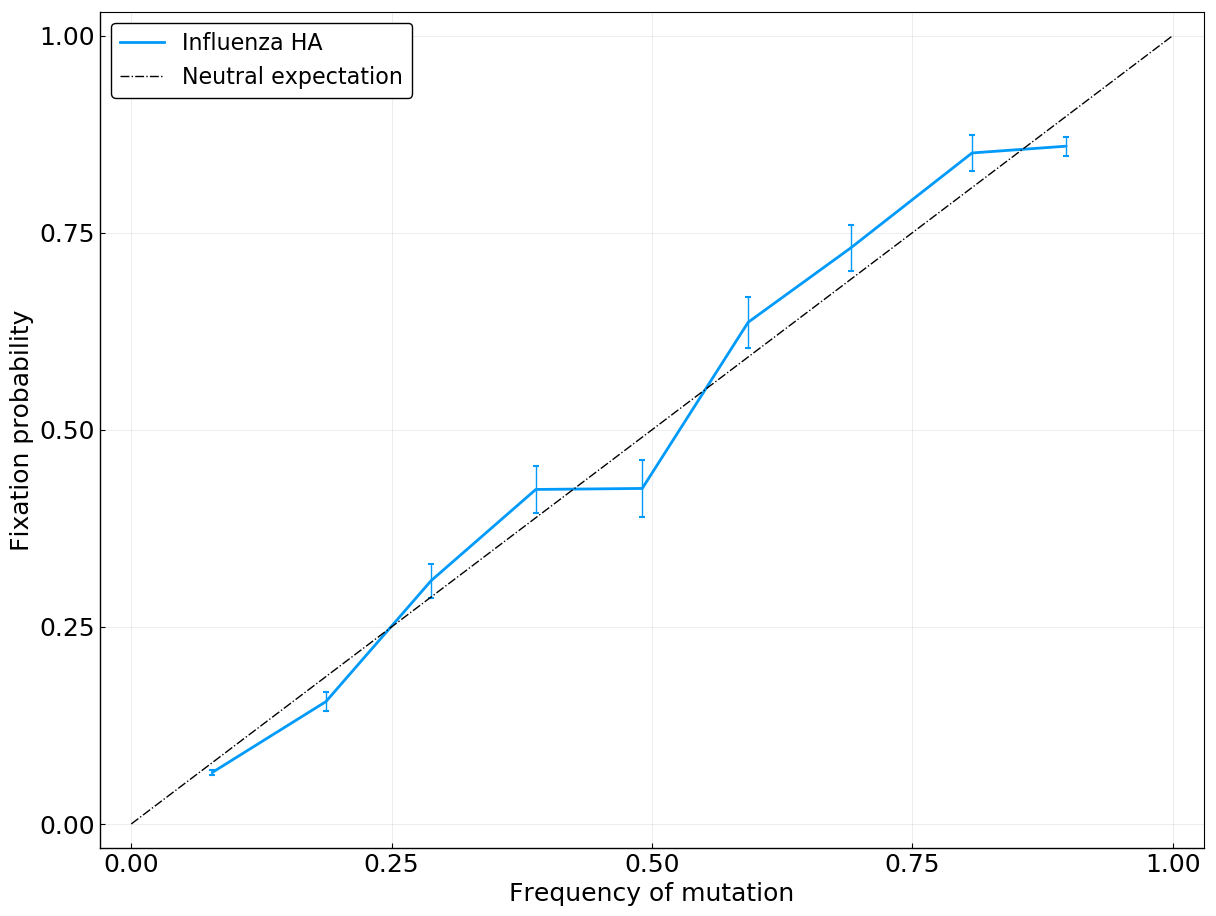

In [154]:
dat = vcat([[meanfreq(traj_fb[x]) pfix(traj_fb[x])] for x in alphabins_]...)
err = [x*(1-x)/sqrt(length(traj_fb[x])) for x in alphabins_]

# 
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], yerr=err, label="Influenza HA", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("LongTerm/Pfix_v_freq_basic.png")

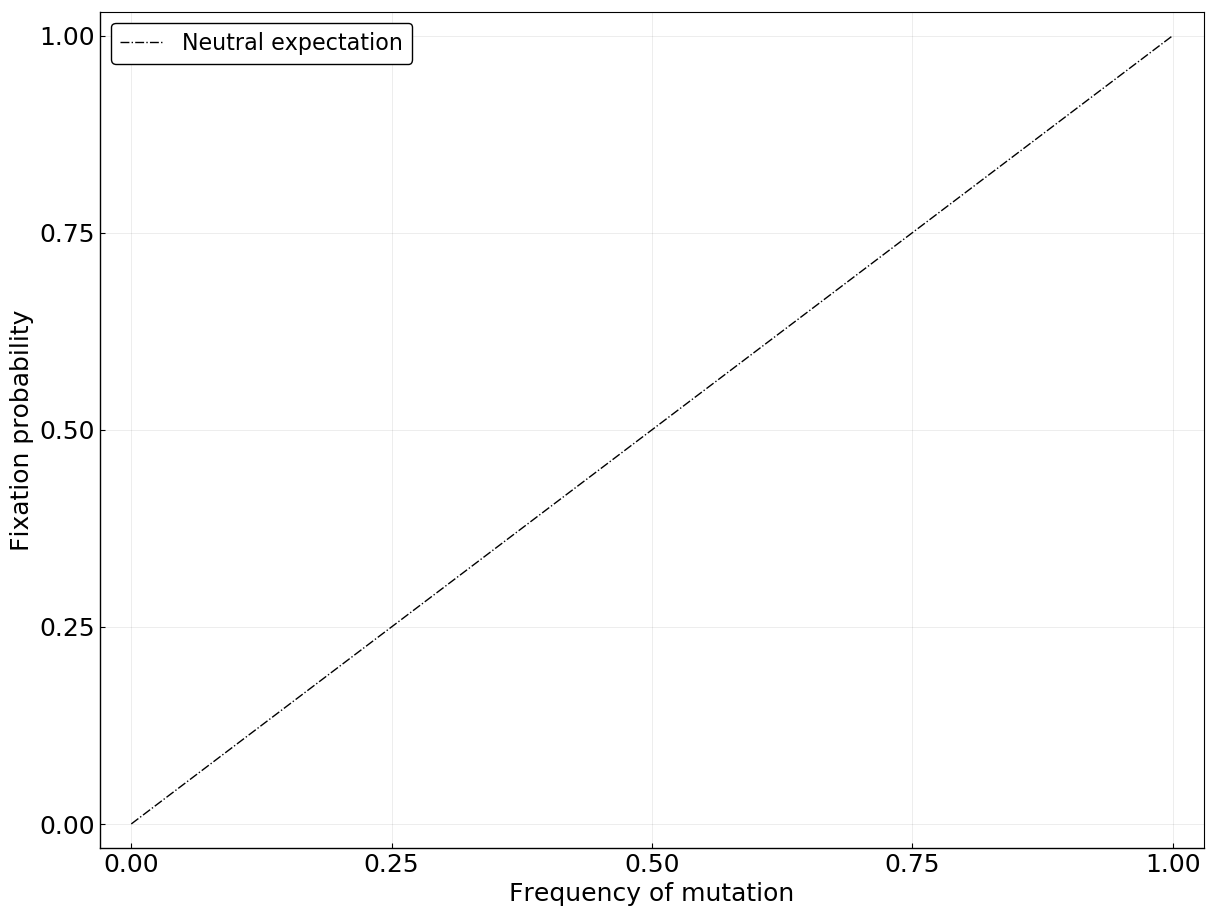

In [175]:
p = plot(size = (1200,900))
# plot!(p, dat[:,1], dat[:,2], yerr=err, label="Influenza HA", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("LongTerm/Pfix_v_freq_neutral.png");

# Treespread

In [155]:
function fitness_plot(trajectories; verbose=false)
    traj_fb = trajectory_freqbin(trajectories, alphabins);
    # Keeping only trajectories that have a frequency backed by 50 strains at the time where it is binned. 
    for (k,v) in traj_fb
        traj_fb[k] = FluTools.population_size_condition(v, 20, mode=:active)
    end   
    # High and low fitnesses
    high_fit = Dict()
    low_fit = Dict()
    for (k,v) in traj_fb
        fvalues = [x.fitness[x.index[:active]] for x in v]
        medfit = median(fvalues)
        verbose && println("Frequency $k -- median fitness $(medfit)")
        high_fit[k] = v[findall(x->x.fitness[x.index[:active]] > medfit, v)]
        low_fit[k] = v[findall(x->x.fitness[x.index[:active]] <= medfit, v)]
    end
    # Arrays
    dat = vcat([[meanfreq(traj_fb[x]) pfix(traj_fb[x])] for x in alphabins_]...)
    dat_low = vcat([[meanfreq(traj_fb[x]) pfix(low_fit[x])] for x in alphabins_]...)
    dat_high = vcat([[meanfreq(traj_fb[x]) pfix(high_fit[x])] for x in alphabins_]...)
    return dat, dat_low, dat_high
end

fitness_plot (generic function with 1 method)

In [156]:
t = read_tree("../../data/trees/tree_building_ha_100permonth/tree_refined.nwk");
mutfile = "../../data/trees/tree_building_ha_100permonth/aa_muts.json"
FluTools.read_mutations!(t, mutfile);

  2.595729 seconds (4.39 M allocations: 678.706 MiB, 60.23% gc time)
NODE_0017638
NODE_0017638
NODE_0017638


In [157]:
for traj in trajectories
    FluTools.compute_tree_spread!(traj, t, sp)
end
FluTools.compute_fitness!(trajectories, sp, ftype=:treespread)
dat, dat_low, dat_high = fitness_plot(trajectories);

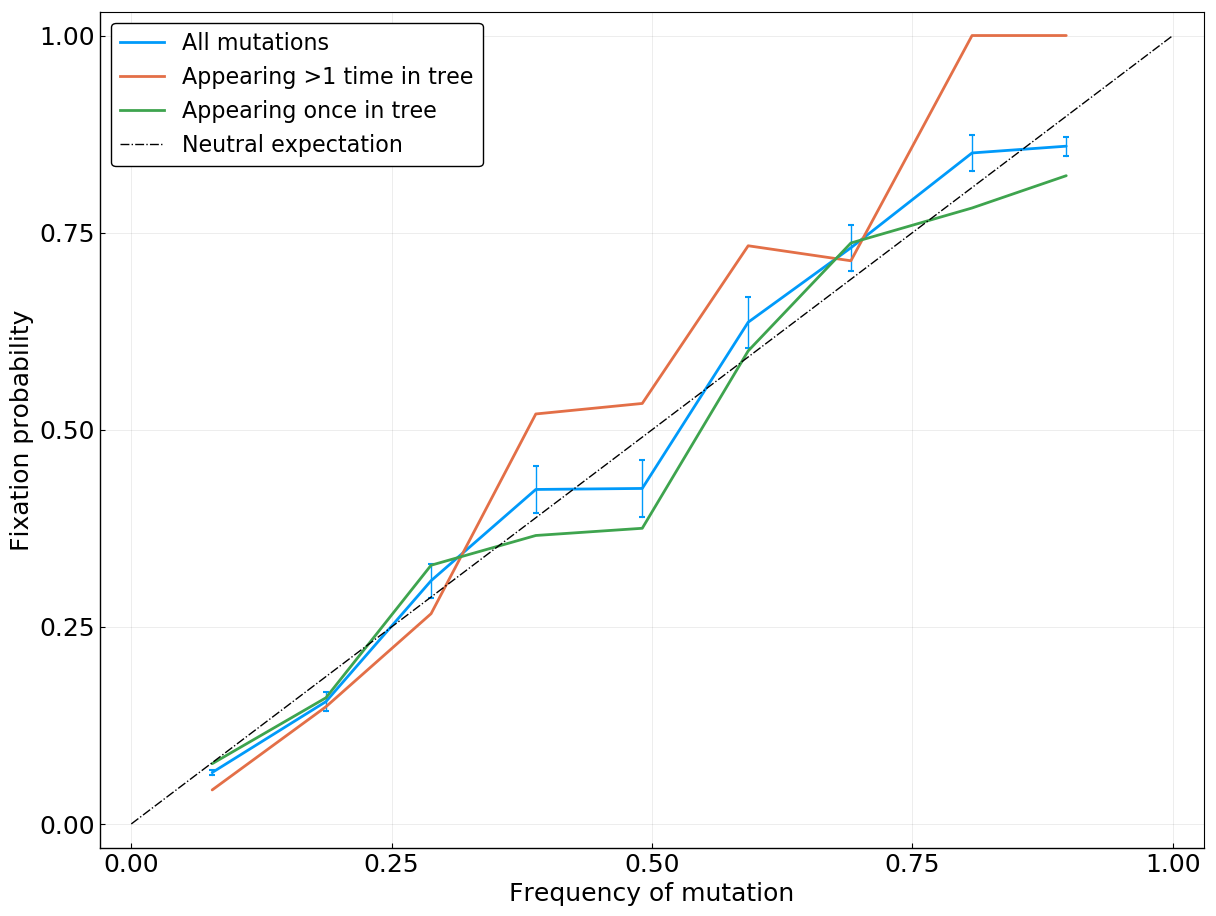

In [158]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], yerr=err, label="All mutations", line=(2))
plot!(p, dat[:,1], dat_high[:,2], label="Appearing >1 time in tree", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Appearing once in tree", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("LongTerm/Pfix_v_freq_treespread.png")

# LBI

In [159]:
t = read_tree("../../data/trees/tree_building_ha_100permonth/tree_refined.nwk", NodeDataType=LBIData);

  1.846226 seconds (4.29 M allocations: 673.216 MiB, 49.49% gc time)


In [160]:
# Strainpop corresponding to tree
# headers = MyBioTools.read_fasta_headers("../../data/trees/tree_building_ha_100permonth/filtered_sequences.fasta")
headers = [x.label for x in values(t.leaves)]
idx = findall(x->in(x.strain, headers), sp.strains)
sp_tree = FluTools.StrainPop(strains = sp.strains[idx]);
FluTools.bin_by_date!(sp_tree, binwidth=binwidth, binspacing = binspacing);


In [161]:
# Trajectories for the new strainpop
ph_tree = FluTools.positions_history(sp_tree);
trajectories_tree = FluTools.all_trajectories(ph_tree, keep_unfinished=false)
trajectories_tree = FluTools.previous_state_condition(trajectories_tree, :lost);
FluTools.get_strains!(trajectories_tree, sp_tree);

In [162]:
@time FluTools.get_lbi!(sp_tree, t, date_leeway = Day(0));

 16.261389 seconds (22.07 k allocations: 340.516 MiB, 13.77% gc time)


In [163]:
FluTools.compute_fitness!(trajectories_tree, sp_tree, ftype=:lbi)
dat, dat_low, dat_high = fitness_plot(trajectories_tree);

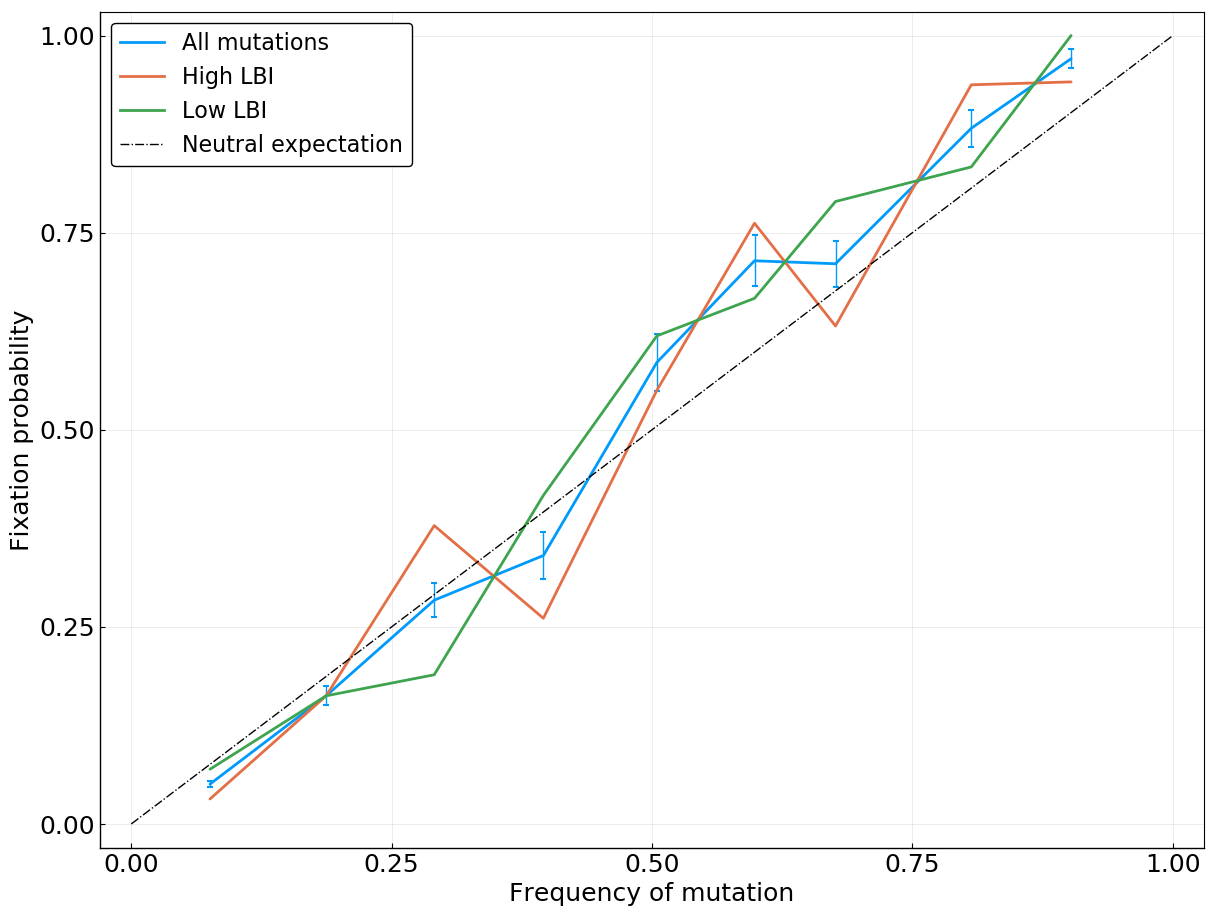

In [164]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], yerr=err, label="All mutations", line=(2))
plot!(p, dat[:,1], dat_high[:,2], label="High LBI", line=(2), color=2)
plot!(p, dat[:,1], dat_low[:,2], label="Low LBI", line=(2), color=3)
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("LongTerm/Pfix_v_freq_LBI.png")

# Date and region

## Date

In [165]:
FluTools.compute_fitness!(trajectories, sp, ftype=:date)
dat, dat_low, dat_high = fitness_plot(trajectories);

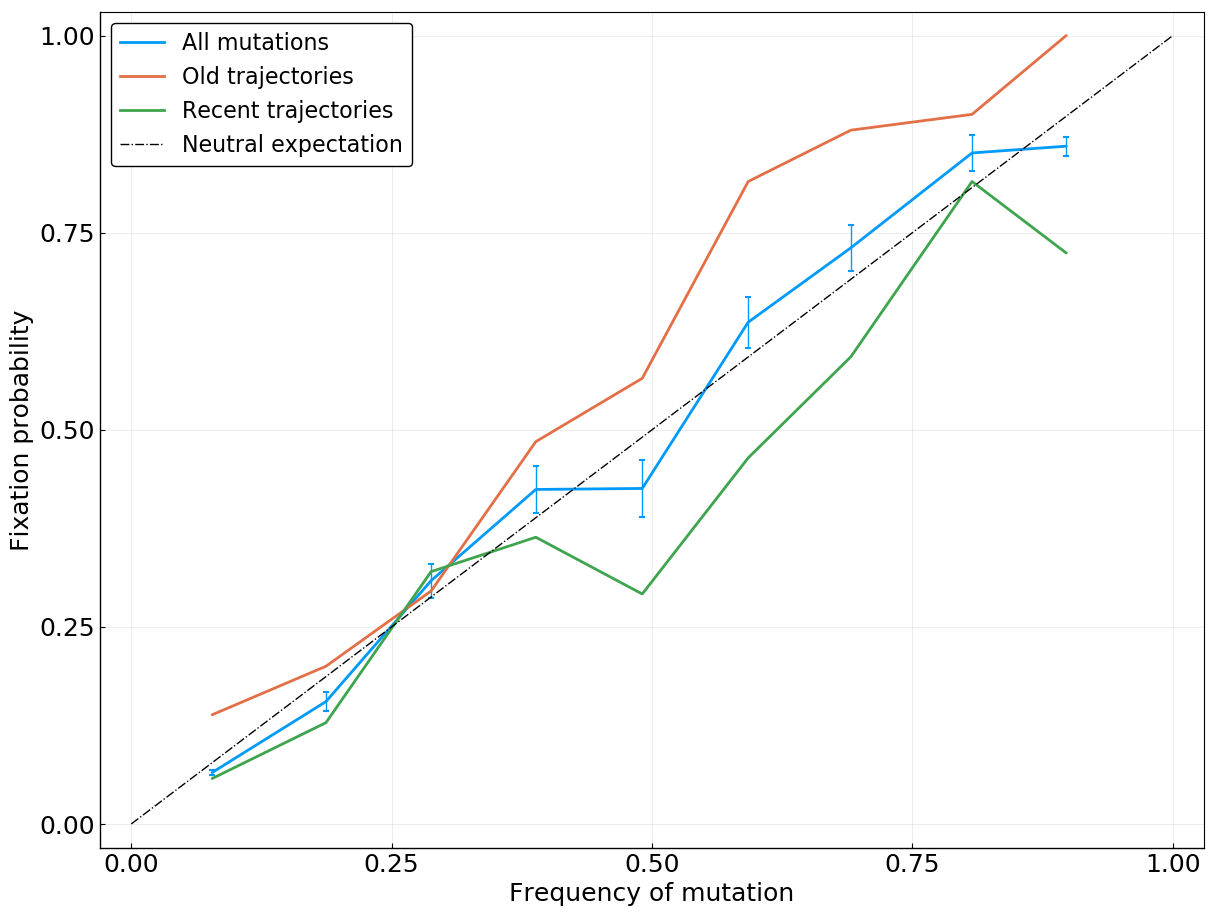

In [166]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], yerr=err, label="All mutations", line=(2))
plot!(p, dat[:,1], dat_high[:,2], label="Old trajectories", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Recent trajectories", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("LongTerm/Pfix_v_freq_date.png")

## Region

In [167]:
FluTools.compute_fitness!(trajectories, sp, ftype=:region)
dat, dat_low, dat_high = fitness_plot(trajectories);

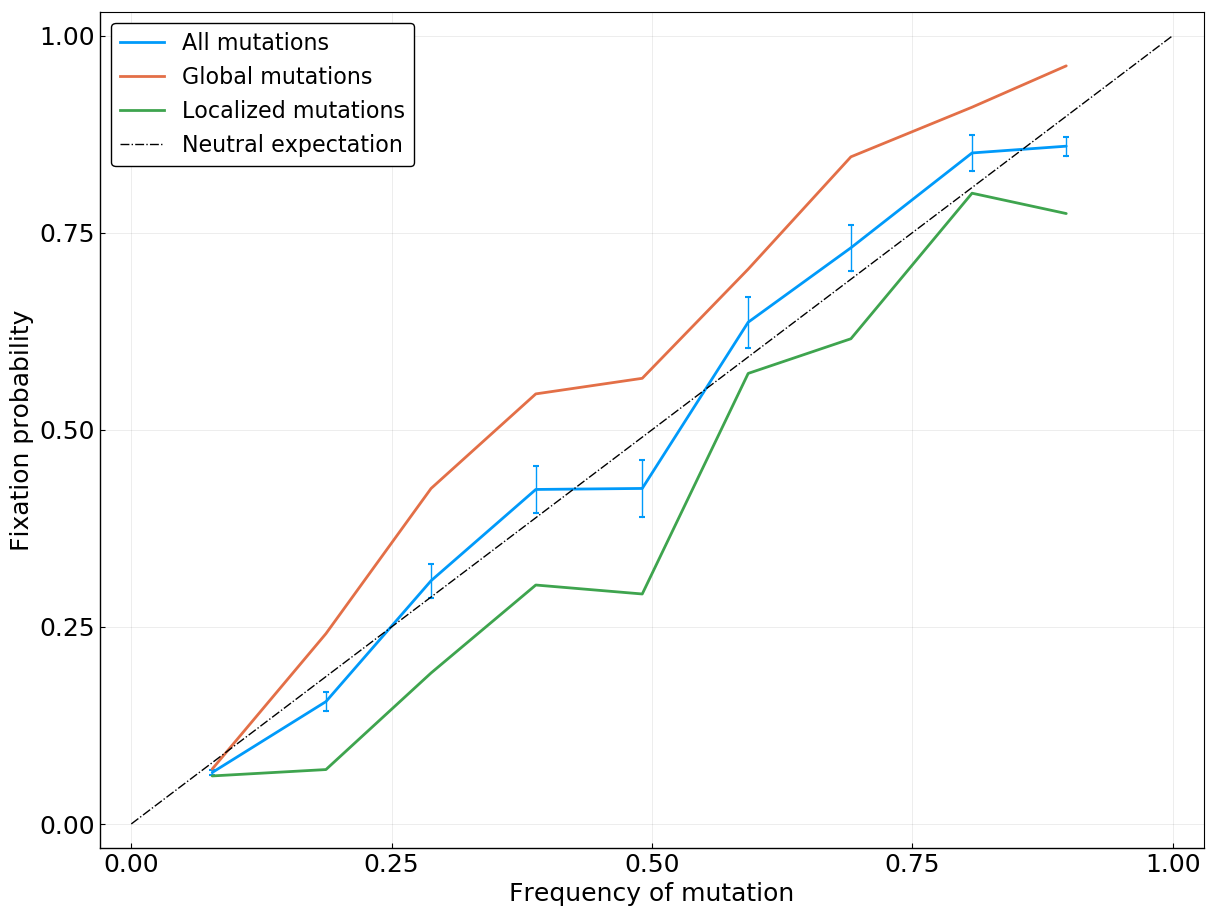

In [168]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], yerr=err, label="All mutations", line=(2))
plot!(p, dat[:,1], dat_high[:,2], label="Global mutations", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Localized mutations", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("LongTerm/Pfix_v_freq_region.png")

# Large timebins

In [52]:
binwidth = Day(90);
binspacing = Day(180);
# startdate = Date(2001)
FluTools.bin_by_date!(sp, binwidth=binwidth, binspacing = binspacing);

In [53]:
ph_all = FluTools.positions_history(sp);

In [54]:
trajectories = FluTools.all_trajectories(ph_all, keep_unfinished=false)
trajectories = FluTools.previous_state_condition(trajectories, :lost)
# trajectories = FluTools.population_size_condition(trajectories, 50, mode=:active);

In [55]:
traj_fb = trajectory_freqbin(trajectories, alphabins);
# Keeping only trajectories that have a frequency backed by 50 strains at the time where it is binned. 
for (k,v) in traj_fb
    traj_fb[k] = FluTools.population_size_condition(v, 25, mode=:active)
end

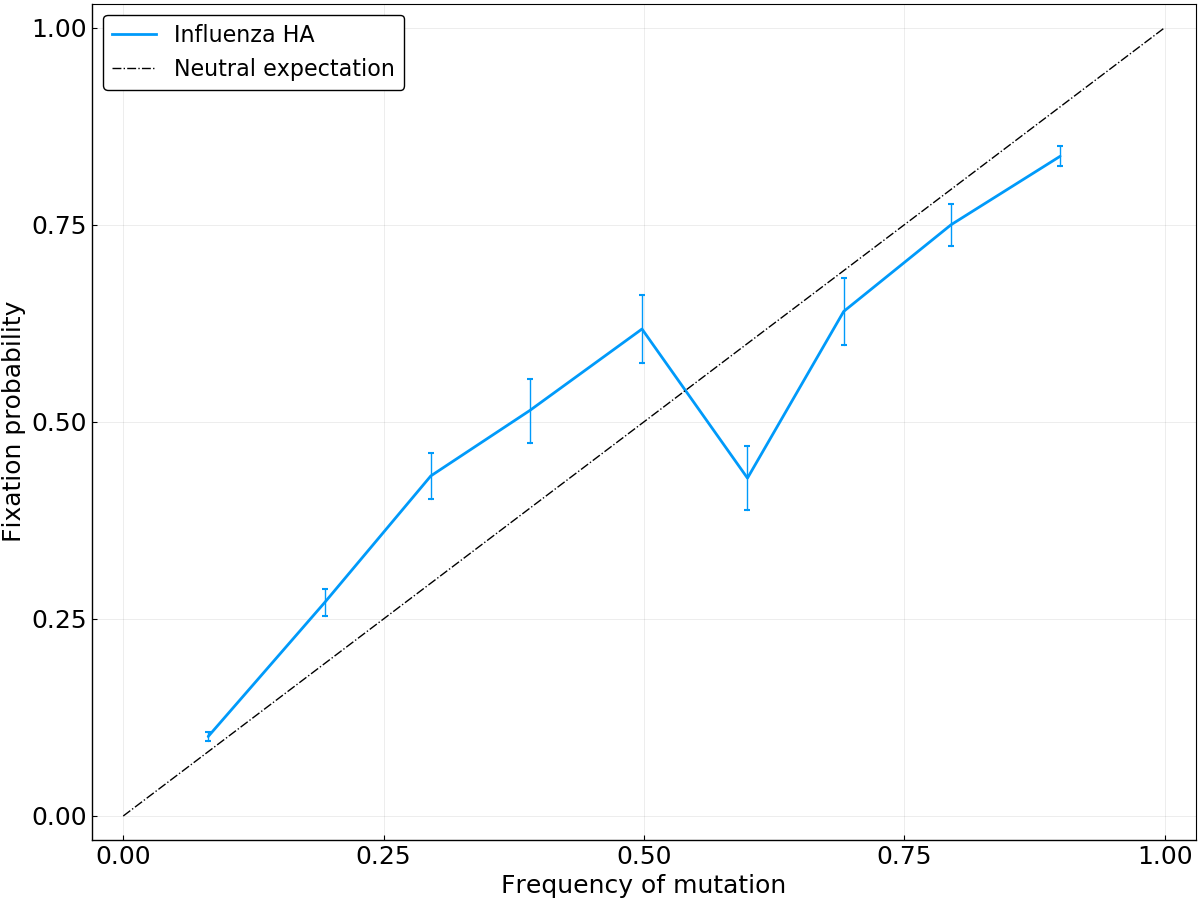

In [56]:
dat = vcat([[meanfreq(traj_fb[x]) pfix(traj_fb[x])] for x in alphabins_]...)
err = [x*(1-x)/sqrt(length(traj_fb[x])) for x in alphabins_]

# 
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], yerr=err, label="Influenza HA", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)

In [57]:
length(traj_fb[0.6])

35